## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%%bash
#ls

In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from MODULES.utilities import show_batch, save_obj, load_obj 
from MODULES.utilities import load_json_as_dict, save_dict_as_json, DatasetInMemory
from MODULES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_interpolation
from MODULES.vae_model import CompositionalVae

#!pip install moviepy
from IPython.display import Image, display, HTML
import moviepy.editor as mpy
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO #,TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 


# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Check versions
print("pyro.__version__  --> ",pyro.__version__)
print("torch.__version__ --> ",torch.__version__)
assert(pyro.__version__.startswith('0.4'))
assert(torch.__version__.startswith('1.2'))

pyro.__version__  -->  0.4.0
torch.__version__ -->  1.2.0


# Get the data

In [5]:
LOCAL_MACHINE=True
if LOCAL_MACHINE:
    batch_size = 4
    data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/" # for local machine
    write_dir  = '/Users/ldalessi/DAPI_unsupervised/spacetx-research/ARCHIVE/' # local machine
    reference_dir = '/Users/ldalessi/DAPI_unsupervised/DATA/'
else:
    batch_size = 128
    #batch_size = 64
    #batch_size = 32
    
    data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/" # V4
    #write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/' # V4
    write_dir  = '/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/' # V4
    reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'

# DISK WITH SHADING WITH BG
#train_dataset = DatasetInMemory(data_dir+"DISK_SHADING/","multi_disk_train_shading_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"DISK_SHADING/","multi_disk_test_shading_bg",use_cuda=torch.cuda.is_available())
    
# DISK WITH SHADING WITHOUT BG
#train_dataset = DatasetInMemory(data_dir+"DISK_SHADING/","multi_disk_train_shading",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"DISK_SHADING/","multi_disk_test_shading",use_cuda=torch.cuda.is_available())

# SUPER SMALL MNIST
#train_dataset = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_train_simple_v3",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_test_simple_v3",use_cuda=torch.cuda.is_available())

# SMALL MNIST
train_dataset = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_train_with_bg",use_cuda=torch.cuda.is_available())
test_dataset  = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_test_with_bg",use_cuda=torch.cuda.is_available())

# BIG MNIST
#train_dataset = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"MULTI_MNIST/","multi_mnist_test_large",use_cuda=torch.cuda.is_available())

# DEBUG FASHION_MNIST
#train_dataset = DatasetInMemory(data_dir+"MULTI_FashionMNIST/","multi_Fashionmnist_train_small_structured_noise",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"MULTI_FashionMNIST/","multi_Fashionmnist_test_small_structured_noise",use_cuda=torch.cuda.is_available())

# REAL FASHION_MNIST
#train_dataset = DatasetInMemory(data_dir+"MULTI_FashionMNIST/","multi_Fashionmnist_train_large_structured_noise",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"MULTI_FashionMNIST/","multi_Fashionmnist_test_large_structured_noise",use_cuda=torch.cuda.is_available())

# DAPI
#train_dataset = DatasetInMemory(data_dir+"DAPI_ONLY_v5/","DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = DatasetInMemory(data_dir+"DAPI_ONLY_v5/","DAPI_dataset_test",use_cuda=torch.cuda.is_available())

Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


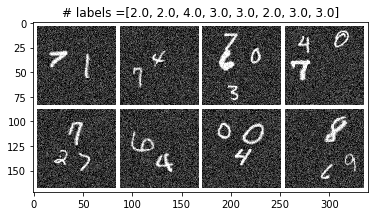

In [6]:
train_dataset.check()

Dataset lenght: 500
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


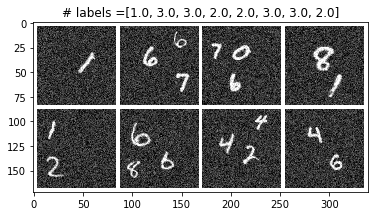

In [7]:
test_dataset.check()

In [8]:
print(test_dataset.labels)
print(torch.min(test_dataset.labels), torch.max(test_dataset.labels))

tensor([2., 2., 2., 4., 2., 2., 3., 3., 2., 2., 4., 3., 4., 2., 3., 3., 2., 3.,
        2., 2., 2., 2., 3., 3., 2., 4., 3., 3., 3., 3., 2., 3., 2., 2., 2., 2.,
        1., 3., 3., 4., 1., 2., 1., 2., 2., 2., 2., 2., 3., 4., 2., 3., 3., 3.,
        2., 2., 3., 3., 3., 2., 2., 3., 5., 4., 3., 1., 2., 3., 2., 3., 3., 3.,
        4., 3., 1., 4., 3., 3., 3., 3., 2., 3., 3., 3., 4., 3., 2., 2., 3., 2.,
        3., 3., 2., 2., 2., 2., 2., 3., 4., 3., 3., 3., 3., 2., 3., 3., 3., 3.,
        3., 4., 2., 3., 2., 3., 3., 3., 2., 2., 2., 2., 2., 3., 3., 4., 3., 2.,
        4., 5., 2., 3., 4., 4., 3., 3., 3., 3., 4., 2., 2., 4., 4., 3., 2., 4.,
        4., 3., 2., 4., 2., 2., 3., 3., 4., 3., 2., 4., 2., 2., 2., 2., 1., 3.,
        4., 3., 2., 3., 3., 3., 4., 2., 2., 4., 3., 3., 2., 3., 2., 2., 2., 4.,
        4., 2., 2., 3., 2., 3., 3., 3., 2., 1., 2., 4., 4., 5., 4., 3., 2., 1.,
        1., 3., 3., 4., 3., 3., 2., 3., 3., 1., 4., 3., 2., 3., 3., 2., 3., 4.,
        3., 1., 3., 3., 2., 3., 2., 3., 

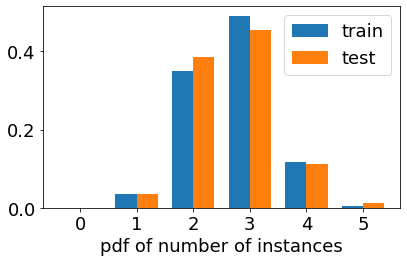

In [20]:
#plt.hold(True)

SIZE = 18
plt.rc('font', size=SIZE)
plt.rc('axes', titlesize=SIZE)

plt.xticks(np.arange(0, 7, step=1))
_ = plt.hist([train_dataset.labels.numpy(), test_dataset.labels.numpy()], bins=6, rwidth=0.75, align='left', 
             range=[0,6], stacked=False, density=True, label=["train","test"])
plt.legend()
plt.xlabel("pdf of number of instances")
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("/Users/ldalessi/Desktop/pdf_mnist.png")

tensor([[[0.0000, 1.6667, 3.3333, 5.0000]]])
tensor([[[0.0000, 0.4167, 1.2500, 2.0833, 2.9167, 3.7500, 4.5833, 5.0000]]])
tensor([[[0.0000, 0.7143, 1.4286, 2.1429, 2.8571, 3.5714, 4.2857, 5.0000]]])


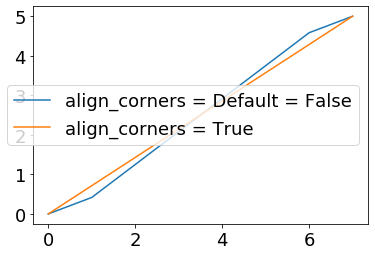

In [36]:
import torch.nn.functional as F

x0= torch.linspace(0,5,4).view(1,1,-1)
x1 = F.interpolate(x0, size=8, mode='linear')
x2 = F.interpolate(x0, size=8, mode='linear', align_corners=True)

print(x0)
print(x1)
print(x2)
plt.plot(x1.view(-1).numpy(), label="align_corners = Default = False")
plt.plot(x2.view(-1).numpy(), label="align_corners = True")
plt.legend()

# OTSU THRESHOLDING

Otsu(threshold=tensor([0.5200], device='cuda:0'), bg_mu=tensor([0.2100], device='cuda:0'), bg_std=tensor([0.1052], device='cuda:0'), fg_mu=tensor([0.8291], device='cuda:0'), fg_std=tensor([0.1460], device='cuda:0'), bg_fraction=tensor([0.7299], device='cuda:0'))


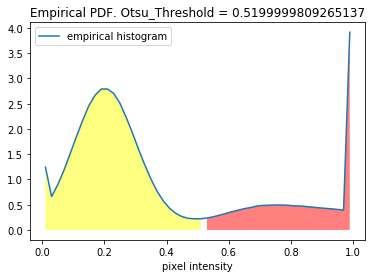

In [8]:
left = 0.0
right = 1.0
nbins = 50
histo, otsu = test_dataset.compute_otsu_parameters(left = left, right = right, nbins = nbins)
print(otsu)

# Make plot
ch = 0
histo_x = histo.x[ch].cpu().numpy()
histo_y = histo.y[ch].cpu().numpy()
n_th = np.argmin( histo_x < otsu.threshold[ch].cpu().numpy())
plt.plot(histo_x,histo_y, label='empirical histogram')
plt.fill_between(histo_x[:n_th], 0, histo_y[:n_th], facecolor='yellow', alpha=0.5)
plt.fill_between(histo_x[n_th:], 0, histo_y[n_th:], facecolor='red', alpha=0.5)

#plt.ylim(ymin=-0.1, ymax=2.5)
#plt.grid(True)
plt.legend(loc='best')
plt.title("Empirical PDF. Otsu_Threshold = "+str(otsu.threshold[ch].item()))
plt.xlabel("pixel intensity")
plt.savefig("./otsu.png")

In [9]:
print(otsu.threshold.cpu().item())

0.5199999809265137


fraction_fg_pixel tensor([0.2089, 0.2698, 0.4412, 0.2155, 0.3706, 0.2256, 0.2580, 0.3603, 0.3556,
        0.2695, 0.2248, 0.2981, 0.2778, 0.3503, 0.3370, 0.4225, 0.2441, 0.1762,
        0.2455, 0.3041, 0.2208, 0.2080, 0.2836, 0.1669, 0.2497, 0.2820, 0.1634,
        0.2788, 0.2619, 0.3395, 0.2467, 0.1762, 0.2542, 0.2492, 0.1091, 0.2795,
        0.2997, 0.2759, 0.3508, 0.3164, 0.3203, 0.3244, 0.2703, 0.2420, 0.3423,
        0.2833, 0.2530, 0.3139, 0.3081, 0.1834, 0.2592, 0.2370, 0.2859, 0.4225,
        0.3981, 0.2287, 0.2136, 0.1841, 0.3113, 0.2627, 0.1939, 0.3919, 0.3202,
        0.1937, 0.3541, 0.2077, 0.3284, 0.2177, 0.2194, 0.1925, 0.2189, 0.3312,
        0.2700, 0.2517, 0.3125, 0.1986, 0.2927, 0.3627, 0.3202, 0.2216, 0.2642,
        0.2833, 0.3266, 0.2500, 0.2998, 0.2470, 0.2430, 0.2317, 0.3034, 0.3172,
        0.2602, 0.2959, 0.2430, 0.2602, 0.3745, 0.2645, 0.2834, 0.2884, 0.2742,
        0.2419, 0.2077, 0.1617, 0.2934, 0.2625, 0.1867, 0.3302, 0.2233, 0.1686,
        0.3567, 0.3964

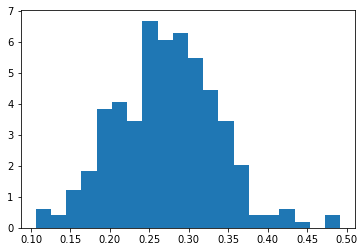

In [10]:
imgs_in, labels = train_dataset.load(256)
n_fg_pixel = torch.sum((imgs_in > otsu.threshold.cpu().item()).float(), dim=(-1, -2, -3))
w, h = imgs_in.shape[-2:]
fraction_fg_pixel = n_fg_pixel/(w*h)

_ = plt.hist(fraction_fg_pixel.cpu().numpy(), density=True, bins=20)
print("fraction_fg_pixel", n_fg_pixel/(w*h))

tensor(4., device='cuda:0')


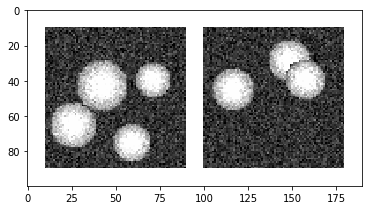

In [11]:
imgs_in, labels = train_dataset.load(8)
print(labels[0])
show_batch(imgs_in[:2])

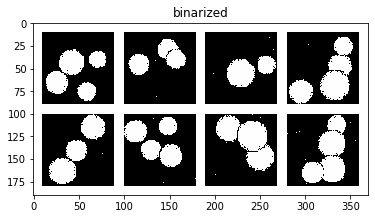

In [12]:
if torch.cuda.is_available():
    imgs_in = imgs_in.cuda() 

binarized = (imgs_in > otsu.threshold[...,None, None]).float()
show_batch(binarized, title = "binarized")

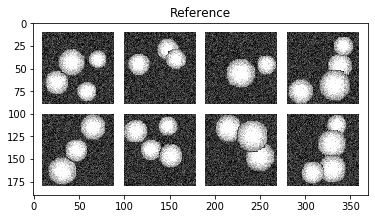

In [13]:
show_batch(imgs_in, title = "Reference")

Text(0.5, 0, 'Average intensity in box of size 15')

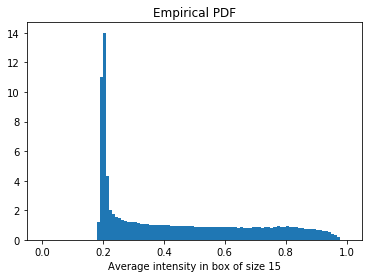

In [14]:
size=15
r = test_dataset.compute_brightness_distribution_window(window_size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

Text(0.5, 0, 'Average intensity in box of size 35')

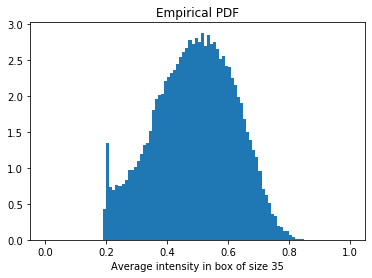

In [15]:
size=35
r = test_dataset.compute_brightness_distribution_window(window_size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [16]:
#descriptor        = "MNIST_prob_corr_factor_to_zero_v10_mask_overlap"
#descriptor        = "MNIST_weak_kl_z_strong_kl_p"
#descriptor        = "MNIST_kl_multiplied_by_typical_box_size_v5"
#descriptor        = "MNIST_rerun_v2"
#descriptor        = "sweep_275072"
#descriptor        = "sweep_59969" 
#descriptor        = "MNIST_rerun_v1"
#descriptor        = "MNIST_rerun_v23"  # smaller boxes
#descriptor        = "MNIST_rerun_v3"  # smaller boxes
#descriptor        = "MNIST_tmp5"
#descriptor        = "MNIST_paper_result_6"
#descriptor        = "DISK_final_v3"
#descriptor        = "DAPI_final_v2"
#descriptor        = "DAPI_point_estimate_plus_noise_v23"
descriptor        = "DISK_point_estimate_plus_noise_v62"

name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
name_soft_constraints = descriptor+"_soft_constraints"
epoch_restart     = 500
is_restart = False
is_pretrained = False
pyro.clear_param_store()
pyro.set_rng_seed(0)

if(is_restart):

    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    
    hyper_params = load_json_as_dict(write_dir,name_hyper_params+"_"+str(epoch_restart))    
    print("")
    print("-HYPER PARAMS-")
    print(hyper_params)
    vae = CompositionalVae.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))    
    
    soft_constraints = load_json_as_dict(write_dir, name_soft_constraints+"_"+str(epoch_restart))
   
    # change overlap value
    #soft_constraints["overlap"]["strength"]=10.0
         
    print("")
    print("-CONSTRAINTS-")
    print(soft_constraints)
    vae.dict_soft_constraints = soft_constraints
    
else:    
    
    epoch_restart = -1
    
    min_loss = 99999999
    history_dict = {}
       
    hyper_params=load_json_as_dict("./", "simulation_dictionary")       
    print("")
    print("-HYPER PARAMS-")
    print(hyper_params)
    vae = CompositionalVae(hyper_params)
    vae.reset()
    
    soft_constraints = load_json_as_dict("./", "soft_constraints")
    print("")
    print("-CONSTRAINTS-")
    print(soft_constraints)   
    vae.dict_soft_constraints = soft_constraints
    
    if(is_pretrained):
        storage_dir = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/PRETRAINED/"
        name_vae_storage = "MNIST_rescale_KL_v51_vae_465"
        vae = CompositionalVae.load(hyper_params,storage_dir,name_vae_storage)
        
save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")


-HYPER PARAMS-
{'global': {'__comment': 'global parameters', 'dim_zwhat': 25, 'dim_zmask': 25, 'cropped_width': 28}, 'unet': {'__comment': 'parameters of the unet. level_zwhere_output is between 0 and n_max_pool included', 'n_max_pool': 4, 'level_zwhere_output': 2, 'level_background_output': 4, 'n_ch_output_features': 32, 'n_ch_after_first_two_conv': 32}, 'input_image': {'__comment': 'parameters describing the input images', 'n_objects_max': 6, 'size_object_min': 10, 'size_object_max': 35, 'size_object_expected': 20, 'size_raw_image': 80, 'ch_in_description': ['DAPI']}, 'nms': {'__comment': 'parameters for the non-max-suppression', 'score_threshold_test': -1, 'score_threshold_train': -1, 'overlap_threshold_test': 0.3, 'overlap_threshold_train': 0.3, 'randomize_nms_factor_test': 0.2, 'randomize_nms_factor_train': 0.2}, 'noise': {'__comment': 'noise to add in tx, ty, tw, th', 'prob_noise': 0.0, 'tx_noise': 0.0, 'ty_noise': 0.0, 'tw_noise': 0.0, 'th_noise': 0.0}, 'loss': {'__comment': 'p

At layer l=  0  we have w_h_j_rf_wloc_hloc=  (80, 80, 1, 1, 0.5, 0.5)
At layer l=  1  we have w_h_j_rf_wloc_hloc=  (80, 80, 1.0, 5, 0.5, 0.5)
At layer l=  2  we have w_h_j_rf_wloc_hloc=  (40, 40, 2.0, 6, 1.0, 1.0)
At layer l=  3  we have w_h_j_rf_wloc_hloc=  (40, 40, 2.0, 14, 1.0, 1.0)
At layer l=  4  we have w_h_j_rf_wloc_hloc=  (20, 20, 4.0, 16, 2.0, 2.0)
At layer l=  5  we have w_h_j_rf_wloc_hloc=  (20, 20, 4.0, 32, 2.0, 2.0)
At layer l=  6  we have w_h_j_rf_wloc_hloc=  (10, 10, 8.0, 36, 4.0, 4.0)
At layer l=  7  we have w_h_j_rf_wloc_hloc=  (10, 10, 8.0, 68, 4.0, 4.0)
At layer l=  8  we have w_h_j_rf_wloc_hloc=  (5, 5, 16.0, 76, 8.0, 8.0)
At layer l=  9  we have w_h_j_rf_wloc_hloc=  (5, 5, 16.0, 140, 8.0, 8.0)
At layer l=  10  we have w_h_j_rf_wloc_hloc=  (10, 10, 8.0, 156, 4.0, 4.0)
At layer l=  11  we have w_h_j_rf_wloc_hloc=  (10, 10, 8.0, 188, 4.0, 4.0)
At layer l=  12  we have w_h_j_rf_wloc_hloc=  (20, 20, 4.0, 196, 2.0, 2.0)
At layer l=  13  we have w_h_j_rf_wloc_hloc=  (20, 

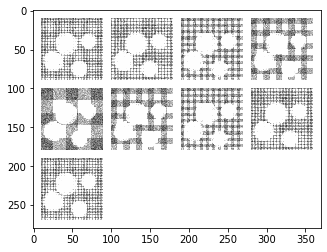

In [17]:
vae.inference_and_generator.unet.describe_receptive_field(imgs_in)
img_with_grid = vae.inference_and_generator.unet.show_grid(imgs_in)
print("img_with_grid.shape",img_with_grid.shape)
show_batch(img_with_grid[:,0])

# Check the constraints

In [18]:
#tmp_dict = vae.dict_soft_constraints['integral_prob_map'] 
#print(tmp_dict)
#vae.dict_soft_constraints['prob_map_integral'] = {}
#vae.dict_soft_constraints['prob_map_integral'] = tmp_dict
#vae.dict_soft_constraints['prob_map_integral'] = tmp 
#vae.dict_soft_constraints
vae.dict_soft_constraints

{'prob_map_fraction': {'__comment': 'the probability map fraction needs to be in a specific range',
  'upper_bound_value': 0.03,
  'upper_bound_width': 0.01,
  'upper_bound_strength': 0.1,
  'upper_bound_exponent': 1},
 'overlap': {'__comment': 'cost which encouranges mask from overlapping',
  'strength': 0.01,
  'exponent': 1.0},
 'volume_mask_fraction': {'__comment': 'the mask volume fraction should be at least 25%',
  'lower_bound_value': 0.2,
  'lower_bound_width': 0.05,
  'lower_bound_strength': 0.1,
  'lower_bound_exponent': 2,
  'upper_bound_value': 0.9,
  'upper_bound_width': 0.05,
  'upper_bound_strength': 0.1,
  'upper_bound_exponent': 2},
 'fg_pixel_fraction': {'__comment': 'Fraction of fg_pixel needs to be in a specific range',
  'lower_bound_value': 0.03,
  'lower_bound_width': 0.02,
  'lower_bound_strength': 0.1,
  'lower_bound_exponent': 2,
  'upper_bound_value': 0.5,
  'upper_bound_width': 0.02,
  'upper_bound_strength': 0.1,
  'upper_bound_exponent': 2},
 'prob_close_t

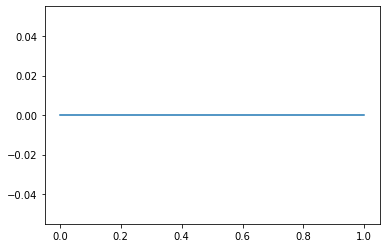

In [19]:
x=torch.linspace(0,1,100)
y=vae.sample_constraints(var_name="prob_close_to_extremes", var_value=x, verbose=False)
plt.plot(x,y)

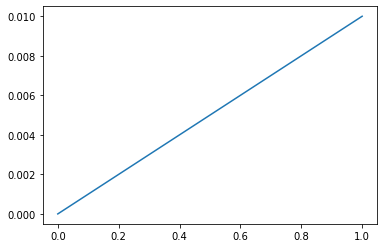

In [20]:
x=torch.linspace(0,1,100)
y=vae.sample_constraints(var_name="overlap", var_value=x, verbose=False)
plt.plot(x,y)

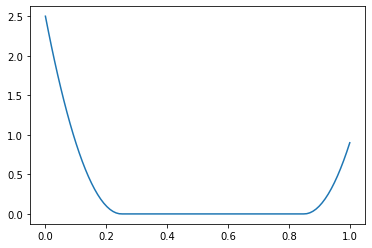

In [21]:
x=torch.linspace(0,1,100)
y=vae.sample_constraints(var_name="volume_mask_fraction", var_value=x, verbose=False)
plt.plot(x,y)

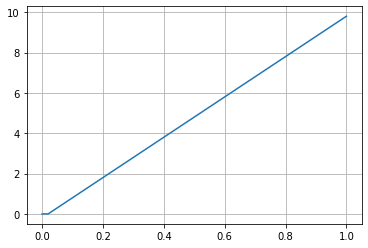

In [22]:
x=torch.linspace(0,1,101)
y=vae.sample_constraints(var_name="prob_map_fraction", var_value=x, verbose=False)
plt.plot(x,y)
plt.grid()
print()

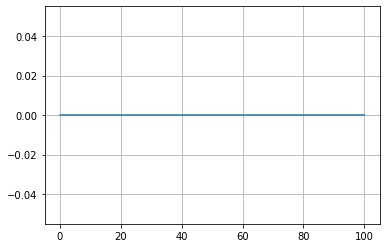

In [23]:
x=torch.linspace(0,100,101)
y=vae.sample_constraints(var_name="prob_map_integral", var_value=x, verbose=False)
plt.plot(x,y)
plt.grid()
print()

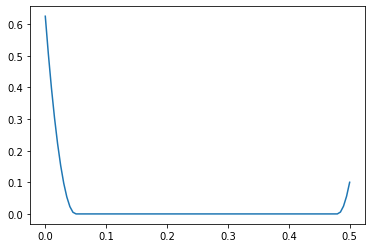

In [24]:
x=torch.linspace(0,0.5,100)
y=vae.sample_constraints(var_name="fg_pixel_fraction", var_value=x, verbose=False)
plt.plot(x,y)

# Nice test to check "constrained" inference

In [25]:
a = vae.inference_and_generator.unet.forward(imgs_in, verbose=True)

INPUT ---> shape  torch.Size([8, 1, 80, 80])
input -> output torch.Size([8, 1, 80, 80]) torch.Size([8, 32, 80, 80])
down    0  shape  torch.Size([8, 32, 80, 80])
appended
input -> output torch.Size([8, 32, 80, 80]) torch.Size([8, 64, 40, 40])
down    1  shape  torch.Size([8, 64, 40, 40])
appended
input -> output torch.Size([8, 64, 40, 40]) torch.Size([8, 128, 20, 20])
down    2  shape  torch.Size([8, 128, 20, 20])
appended
input -> output torch.Size([8, 128, 20, 20]) torch.Size([8, 256, 10, 10])
down    3  shape  torch.Size([8, 256, 10, 10])
appended
input -> output torch.Size([8, 256, 10, 10]) torch.Size([8, 512, 5, 5])
down    4  shape  torch.Size([8, 512, 5, 5])
x_from_compressing_path torch.Size([8, 256, 10, 10])
x_to_upconv torch.Size([8, 512, 5, 5])
after_upconv torch.Size([8, 256, 10, 10])
after concat torch.Size([8, 512, 10, 10])
ch_in 512
up      0  shape  torch.Size([8, 256, 10, 10])
x_from_compressing_path torch.Size([8, 128, 20, 20])
x_to_upconv torch.Size([8, 256, 10, 10])

imgs_in.shape torch.Size([2, 1, 80, 80])
prob.shape torch.Size([6, 2])
imgs_comparison.shape -------------> torch.Size([4, 3, 80, 80])
no_corr_topk_only.prob[:,0] tensor([0.6176, 0.6280, 0.6032, 0.6015, 0.6086, 0.5898], device='cuda:0')
no_corr_with_nms.prob[:,0] tensor([0.5883, 0.6176, 0.6032, 0.5859, 0.5870, 0.6181], device='cuda:0')
with_corr_topk_only.prob[:,0] tensor([0.9753, 0.9277, 0.9046, 0.8821, 0.9512, 0.8385], device='cuda:0')
with_corr_with_nms.prob[:,0] tensor([0.9753, 0.8385, 0.7969, 0.4595, 0.3798, 0.3041], device='cuda:0')


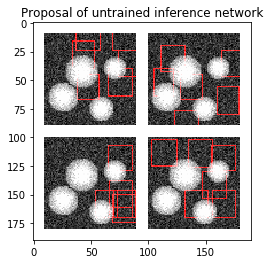

In [26]:
with torch.no_grad():
    imgs_in = imgs_in[:2]
    #vae.inference.box_nms.overlap_threshold=0.2
    no_corr_topk_only, kl = vae.inference_and_generator.forward(imgs_in,
                                                                prob_corr_factor=0.0,
                                                                disk_corr_factor=1.0,
                                                                overlap_threshold=0.2,
                                                                score_threshold=-1.0,
                                                                randomize_nms_factor=0.1,
                                                                n_objects_max=6,
                                                                topk_only=True,
                                                                noisy_sampling=False)
    
    no_corr_with_nms, kl = vae.inference_and_generator.forward(imgs_in,
                                                               prob_corr_factor=0.0,
                                                               disk_corr_factor=1.0,
                                                               overlap_threshold=0.2,
                                                               score_threshold=-1.0,
                                                               randomize_nms_factor=0.1,
                                                               n_objects_max=6,
                                                               topk_only=False,
                                                               noisy_sampling=False)
    
    with_corr_topk_only, kl  = vae.inference_and_generator.forward(imgs_in,
                                                                   prob_corr_factor=1.0,
                                                                   disk_corr_factor=1.0,
                                                                   overlap_threshold=0.2,
                                                                   score_threshold=-1.0,
                                                                   randomize_nms_factor=0.1,
                                                                   n_objects_max=6,
                                                                   topk_only=True,
                                                                   noisy_sampling=False)
    
    with_corr_with_nms, kl = vae.inference_and_generator.forward(imgs_in,
                                                                 prob_corr_factor=1.0,
                                                                 disk_corr_factor=0.0,
                                                                 overlap_threshold=0.2,
                                                                 score_threshold=-1.0,
                                                                 randomize_nms_factor=0.1,
                                                                 n_objects_max=6,
                                                                 topk_only=False,
                                                                 noisy_sampling=False)

    w,h = imgs_in.shape[-2:]
    print("imgs_in.shape",imgs_in.shape)
    print("prob.shape",no_corr_topk_only.prob.shape)
    
    bb_no_corr_topk_only = vae.draw_bounding_boxes(prob = no_corr_topk_only.prob, 
                                                   bounding_box = no_corr_topk_only.bounding_box,
                                                   width = w,
                                                   height = h)
    bb_no_corr_with_nms  = vae.draw_bounding_boxes(prob = no_corr_with_nms.prob,
                                                   bounding_box = no_corr_with_nms.bounding_box,
                                                   width = w,
                                                   height = h)
    bb_with_corr_topk_only = vae.draw_bounding_boxes(prob = with_corr_topk_only.prob,
                                                     bounding_box = with_corr_topk_only.bounding_box,
                                                     width = w,
                                                     height = h)
    bb_with_corr_with_nms  = vae.draw_bounding_boxes(prob = with_corr_with_nms.prob,
                                                     bounding_box = with_corr_with_nms.bounding_box,
                                                     width = w,
                                                     height = h)
    
    imgs_no_corr_topk_only = bb_no_corr_topk_only + imgs_in
    imgs_no_corr_with_nms  = bb_no_corr_with_nms  + imgs_in
    imgs_with_corr_topk_only = bb_with_corr_topk_only + imgs_in
    imgs_with_corr_with_nms  = bb_with_corr_with_nms  + imgs_in
    
how_many_to_show = 1    
imgs_comparison = torch.cat((imgs_no_corr_topk_only[:how_many_to_show],
                             imgs_no_corr_with_nms[:how_many_to_show],
                             imgs_with_corr_topk_only[:how_many_to_show],
                             imgs_with_corr_with_nms[:how_many_to_show]),dim=0)   

print("imgs_comparison.shape ------------->",imgs_comparison.shape)
print("no_corr_topk_only.prob[:,0]",no_corr_topk_only.prob[:,0].view(-1))
print("no_corr_with_nms.prob[:,0]",no_corr_with_nms.prob[:,0].view(-1))
print("with_corr_topk_only.prob[:,0]",with_corr_topk_only.prob[:,0].view(-1))
print("with_corr_with_nms.prob[:,0]",with_corr_with_nms.prob[:,0].view(-1))
show_batch(imgs_comparison,n_col=2,n_padding=10,title="Proposal of untrained inference network")

# Check masks

torch.Size([6, 2, 1, 80, 80])
0.0 0.5942373871803284


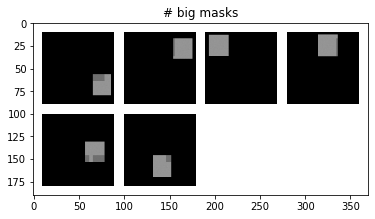

In [27]:
big_mask = with_corr_with_nms.big_mask
print(big_mask.shape)
mymin = torch.min(big_mask).item()
mymax = torch.max(big_mask).item()
print(mymin, mymax)
show_batch(big_mask[:,0], title="# big masks")

torch.Size([2, 1, 80, 80])
0.0 0.8766520023345947


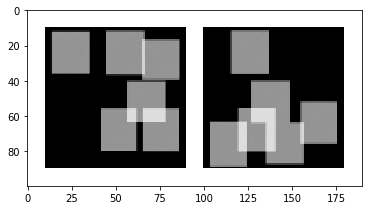

In [28]:
sum_big_masks = torch.sum(big_mask, dim=-5)
print(sum_big_masks.shape)
mymin = torch.min(sum_big_masks).item()
mymax = torch.max(sum_big_masks).item()
print(mymin, mymax)
show_batch(sum_big_masks)

# Check imgs

torch.Size([6, 2, 1, 80, 80])
0.0 0.5189434885978699


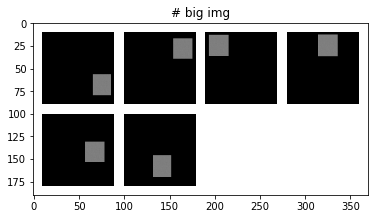

In [29]:
print(with_corr_with_nms.big_img.shape)
mymin = torch.min(with_corr_with_nms.big_img).item()
mymax = torch.max(with_corr_with_nms.big_img).item()
print(mymin, mymax)
show_batch(with_corr_with_nms.big_img[:,0], title="# big img")

0.0 1.013808250427246


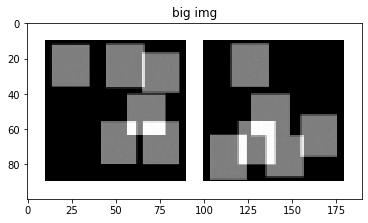

In [30]:
tmp = torch.sum(with_corr_with_nms.big_img, dim=-5)
mymin = torch.min(tmp).item()
mymax = torch.max(tmp).item()
print(mymin, mymax)
show_batch(tmp, title="big img")

0.0 0.4420381188392639


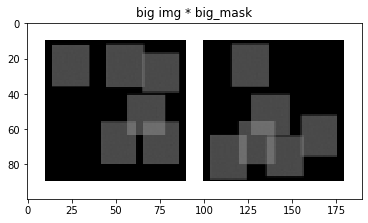

In [31]:
tmp = torch.sum(with_corr_with_nms.big_img * with_corr_with_nms.big_mask, dim=-5)
mymin = torch.min(tmp).item()
mymax = torch.max(tmp).item()
print(mymin, mymax)
show_batch(tmp, title="big img * big_mask")

## Global parameters

In [32]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 50001
    
# setup the optimizer
def per_param_args(module_name, param_name):
    if 'geco_x' in param_name or 'geco_x' in module_name:
        return {"lr": vae.geco_dict["base_lr"], "betas" : vae.geco_dict["betas"], "eps" : vae.geco_dict["eps"]}  # this is short memory
    else:
        return {"lr": vae.loss_dict["base_lr"], "betas": vae.loss_dict["betas"], "eps" : vae.loss_dict["eps"]}
    
scheduler_is_active = True
if scheduler_is_active:
    scheduler_args = {'optimizer': torch.optim.Adam, 
                      'step_size' : 100, 'gamma' : 0.75, 
                      'optim_args' : per_param_args}
    scheduler = pyro.optim.StepLR(scheduler_args)
    svi = SVI(vae.model, vae.guide, scheduler, loss=Trace_ELBO(max_plate_nesting=1))
else:
    optimizer = pyro.optim.Adam(per_param_args)
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(max_plate_nesting=1))

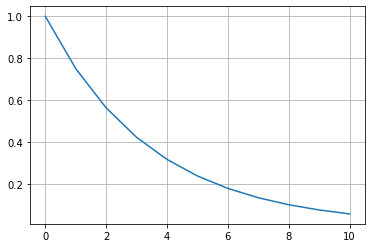

In [33]:
gamma=0.75
x = 1
a = [x]
for n in range(10):
    x *= gamma
    a.append(x)
    
plt.plot(a)
plt.grid()

# Actual train loop

In [ ]:
### training loop
#epoch_restart = 500
for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
    vae.train()   
    
    vae.is_geco_selftuning = (epoch > 100)
    vae.geco_goal = linear_interpolation(epoch, 
                                         values=hyper_params["GECO"]["goal"],
                                         times=hyper_params["GECO"]["times"])
    
    #vae.is_geco_selftuning = (epoch > hyper_params["GECO"]["initial_time"])
    #vae.geco_goal = hyper_params["GECO"]["goal"]
    #vae.is_geco_selftuning = (epoch > 100)
    #vae.geco_goal = 1.0
    #vae.geco_goal = linear_interpolation(epoch, 
    #                                     values=[2.0, 1.0],
    #                                     times=[100, 400])
    
    #vae.is_geco_selftuning = False
    #vae.geco_mu_detached = linear_interpolation(epoch, 
    #                                            values=[0.95,0.5],
    #                                            times=[100,500])
    
    vae.prob_corr_factor=linear_interpolation(epoch, 
                                              values=hyper_params["training_prob_corr_factor"]["values"],
                                              times=hyper_params["training_prob_corr_factor"]["times"])
    
    vae.disk_corr_factor=linear_interpolation(epoch, 
                                              values=hyper_params["training_disk_corr_factor"]["values"],
                                              times=hyper_params["training_disk_corr_factor"]["times"])
        
    #with torch.autograd.set_detect_anomaly(True):
    with torch.autograd.set_detect_anomaly(False):
        loss = train_one_epoch(svi, train_dataset, batch_size, verbose=(delta_epoch==1))
    if scheduler_is_active:
        scheduler.step(epoch=epoch)
     
    try: 
        history_dict["train_loss"].append(loss)    
        history_dict["geco_mu"].append(vae.geco_mu_detached.item())
    except KeyError:
        history_dict["train_loss"] = [loss]
        history_dict["geco_mu"] = [vae.geco_mu_detached.item()] 

    #print("geco_goal, geco_mu", vae.geco_goal, vae.geco_mu_detached.item())
    print("geco_mu geco_goal", vae.geco_mu_detached.item(), vae.geco_goal)
    
    for k,v in vae.input_dict.items():
        try:
            history_dict[k].append(v.item())
        except KeyError:
            history_dict[k] = [v.item()]
    for k,v in vae.ma_dict.items():
        try:
            history_dict[k+"_MA"].append(v.item())
        except KeyError:
            history_dict[k+"_MA"] = [v.item()]
            
    print("[epoch %03d] train loss: %.4f NLL: %.4f prob_factor %.4f disk_factor %.4f" % (epoch, loss, history_dict["nll_total_raw"][-1], vae.prob_corr_factor, vae.disk_corr_factor))

            
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        results_clean = vae.check_accuracy(test_dataset, batch_size, clean=True)
        results_noisy = vae.check_accuracy(test_dataset, batch_size, clean=False)
        
        loss_clean = results_clean.loss.item()
        accuracy_clean = results_clean.n_corrects/(results_clean.n_corrects+results_clean.n_errors)
        n_obj_clean = results_clean.n_objects.item()
        
        loss_noisy = results_noisy.loss.item()
        accuracy_noisy = results_noisy.n_corrects/(results_noisy.n_corrects+results_noisy.n_errors)
        n_obj_noisy = results_noisy.n_objects.item()
        
        print("[epoch %03d] test clean: %.4f accuracy: %.4f n_obj: %.4f" % (epoch, loss_clean, accuracy_clean, n_obj_clean))
        print("[epoch %03d] test noisy: %.4f accuracy: %.4f n_obj: %.4f" % (epoch, loss_noisy, accuracy_noisy, n_obj_noisy))
              
        try:
            history_dict["test_loss_clean"].append(loss_clean)
            history_dict["accuracy_clean"].append(accuracy_clean)
            history_dict["n_obj_clean"].append(n_obj_clean)
            history_dict["test_loss_noisy"].append(loss_noisy)
            history_dict["accuracy_noisy"].append(accuracy_noisy)
            history_dict["n_obj_noisy"].append(n_obj_noisy)
        except KeyError:
            history_dict["test_loss_clean"] = [loss_clean]
            history_dict["accuracy_clean"] = [accuracy_clean]
            history_dict["n_obj_clean"] = [n_obj_clean]
            history_dict["test_loss_noisy"] = [loss_noisy]
            history_dict["accuracy_noisy"] = [accuracy_noisy]
            history_dict["n_obj_noisy"] = [n_obj_noisy]
            
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_dict_as_json(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))
            save_dict_as_json(vae.dict_soft_constraints,write_dir,name_soft_constraints+"_"+str(epoch))

i =   0 train_loss=2404.17432
i =   1 train_loss=1329.71838
i =   2 train_loss=1481.14453
i =   3 train_loss=1132.70190
i =   4 train_loss=1041.42419
i =   5 train_loss=974.61029
i =   6 train_loss=903.64258
i =   7 train_loss=829.04187
i =   8 train_loss=749.97278
i =   9 train_loss=715.30945
i =  10 train_loss=683.18396
i =  11 train_loss=664.58887
i =  12 train_loss=630.87628
i =  13 train_loss=614.85187
i =  14 train_loss=589.04681
i =  15 train_loss=366.27112
geco_mu geco_goal 0.949999988079071 1.2
[epoch 000] train loss: 7.5553 NLL: 3.8364 prob_factor 0.5000 disk_factor 0.5000
[epoch 000] test clean: 4.2293 accuracy: 0.0000 n_obj: 157.0000
[epoch 000] test noisy: 4.2127 accuracy: 0.0000 n_obj: 77.0000
geco_mu geco_goal 0.949999988079071 1.2
[epoch 001] train loss: 3.9152 NLL: 3.2788 prob_factor 0.5000 disk_factor 0.5000
geco_mu geco_goal 0.949999988079071 1.2
[epoch 002] train loss: 3.5856 NLL: 3.4536 prob_factor 0.5000 disk_factor 0.5000
geco_mu geco_goal 0.949999988079071 1.2
[

In [ ]:
vae.input_dict

# Check the results

In [ ]:
history_dict.keys()

In [ ]:
for k,v in history_dict.items():
    print(k," -->", history_dict[k][-3:])

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift,'-')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss_clean"])*TEST_FREQUENCY,TEST_FREQUENCY), sign*np.array(history_dict["test_loss_clean"])+y_shift, '.--')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss_noisy"])*TEST_FREQUENCY,TEST_FREQUENCY), sign*np.array(history_dict["test_loss_noisy"])+y_shift, 'x--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax=2)
plt.grid(True)
plt.legend(['train', 'test_clean', 'test_noisy'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('n objects', color=color)
ax1.plot(np.arange(0, len(history_dict["n_obj_clean"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["n_obj_clean"], 'o', color=color, label="clean")
ax1.plot(np.arange(0, len(history_dict["n_obj_noisy"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["n_obj_noisy"], '-', color=color, label="noisy")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax1.set_ylim([1000,1870])
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(history_dict["accuracy_clean"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["accuracy_clean"],'x', color=color, label="clean")
ax2.plot(np.arange(0, len(history_dict["accuracy_noisy"])*TEST_FREQUENCY, TEST_FREQUENCY),history_dict["accuracy_noisy"],'-', color=color, label="noisy")
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
#ax2.set_ylim([0.97,1.0])
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(write_dir+name_vae+'_accuracy_difference.png')

In [ ]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(np.array(history_dict["sparsity_raw"]),'-',label='sparsity_raw')
#ax.set_ylim([0,10])
ax.grid()
ax.legend()

ax2.plot(np.array(history_dict["kl_zwhat_raw"]),'-',label='kl zwhat')
ax2.plot(np.array(history_dict["kl_zmask_raw"]),'-',label='kl zmask')
ax2.grid()
ax2.set_ylim([0,2])
ax2.legend()

#ax3.plot(history_dict["soft_cost_total_raw"],'-',label='cost total')
ax3.plot(0.1*np.array(history_dict["overlap"]),'-',label='cost overlap')
ax3.plot(history_dict["fg_pixel_fraction"],'-',label='cost fg_pixel_fraction')
ax3.plot(history_dict["prob_map_integral"],'-',label='cost prob_map_integral')
ax3.plot(history_dict["volume_mask_fraction"],'-',label='cost volume_mask_fraction')
ax3.plot(history_dict["prob_close_to_extremes"],'-',label='cost prob_close_to_extremes')
ax3.grid()
#ax3.set_ylim([0,0.2])
ax3.legend()

ax4.plot(history_dict["nll_total_raw"],'-',label='nll_tot_raw')
ax4.plot(history_dict["train_loss"],'-',label='train loss')
ax4.grid()
#ax4.set_ylim([6000,10000])
ax4.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [ ]:
history_dict.keys()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('epochs')
ax1.set_ylabel('GECO x', color=color)
plt.plot(history_dict["geco_mu"],'.',label="geco_mu",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax1.set_ylim([0,1.1])
#plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('nll_total', color=color)  # we already handled the x-label with ax1
ax2.plot(history_dict["nll_total_raw"],'-',label="nll_total_raw",color=color)
#ax2.plot(history_dict["nll_total_raw_MA"],'.--',label="nll_total_raw_MA",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot([1.4]*len(history_dict["nll_total_raw"]),'-',label="threshold",color="black")
ax2.plot([1.0]*len(history_dict["nll_total_raw"]),'-',label="threshold",color="black")
#ax2.set_ylim([0,2])
#ax2.set_xlim([0,1])
ax2.grid()
#plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(write_dir+name_vae+'_geco_mu.png')

In [ ]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

how_many = 400
scale= 1
N = len(history_dict["nll_total_raw"][-how_many :])
colors = np.arange(0.0,N,1.0)/N

#plt.yscale('log')
#plt.xlim(xmin=1.0, xmax=1.5)
plt.xlabel('REC',fontsize=fontsize)
plt.ylabel('REG',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)
plt.scatter(history_dict["nll_total_raw"][-how_many :], history_dict["kl_total_raw"][-how_many :],c=colors)
plt.plot(history_dict["nll_total_raw"][-how_many :], history_dict["kl_total_raw"][-how_many :], '-')
plt.grid()
#plt.xlim(xmax=2.5)
plt.savefig(write_dir+name_vae+'_kl_trajectory.png')

# Check accuracy

In [ ]:
#epoch=100
#vae.load_everything(write_dir,name_vae+"_"+str(epoch))

accuracy_result = vae.check_accuracy(test_dataset, batch_size=8)
print("accuracy ---> ",accuracy_result.n_corrects/(accuracy_result.n_corrects+accuracy_result.n_errors))
print("difference -> ",accuracy_result.diff)
print("diff_abs ---> ",accuracy_result.diff_abs)
print("n_tested ---> ",accuracy_result.n_corrects+accuracy_result.n_errors)
print(accuracy_result.list_wrong_examples)
tmp_list = accuracy_result.list_wrong_examples 

#print(tmp_list)
#tmp_list = [219] * 8
#tmp_list = [435, 10, 219] * 3
#tmp_list = [196, 133, 24, 167, 275, 216, 451, 263, 109]
#tmp_list = [10, 311, 219]
#tmp_list = [219]*3


In [ ]:
#tmp_list = [275]
#tmp_list = [216]
#tmp_list = [243, 435, 219, 201, 113, 83, 100, 227, 448, 140]
#tmp_list = [201, 219, 435, 83]
#tmp_list = [219, 314]*5
#tmp_list = [219, 10, 421]*3
#tmp_list = [10, 105, 24, 435, 219]*2
#tmp_list = [196, 133, 24, 167, 275, 216, 451, 263, 109]
#tmp_list =[219, 435, 83]*3
#tmp_list =[201, 219, 79, 100]*2
#tmp_list =[201, 283, 219, 435, 100, 62]*2
#tmp_list = [435]*9
#tmp_list = [10, 219, 314]
#tmp_list = [10, 219, 314, 113, 83, 100, 227, 448, 140]
#tmp_list = [226, 435, 10, 219, 113, 225]
#tmp_list = [466, 427, 219]
tmp_list = [148, 291, 1, 2, 3, 4, 5, 6, 8, 9]
tmp_list = [488, 454, 491, 347, 75, 116, 215, 301, 49, 142, 309]

In [ ]:
from matplotlib import pyplot as mp

#name='reference_mMNIST_v2'
name='reference_disks_v3'
#name='reference_dapi'

# create image if necessary
#reference_imgs, labels=test_dataset.load(batch_size=len(accuracy_result.list_wrong_examples), indices=accuracy_result.list_wrong_examples)
#reference_imgs, labels=test_dataset.load(batch_size=2, indices=accuracy_result.list_wrong_examples)
#reference_imgs, labels=test_dataset.load(batch_size=8)
#reference_imgs, labels=test_dataset.load(batch_size=9)
reference_imgs, labels=test_dataset.load(batch_size=9, indices=tmp_list)
save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
b = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")
b.savefig(write_dir+name+'_reference.png')
display(b)

# Clean vs Noisy reconstruction

In [ ]:
print("clean reconstruction")
output_clean = vae.reconstruct_img(reference_imgs,draw_bounding_box=True,verbose=True, chosen=0)

print("-")
print("---------")
print("-")

print("noisy reconstruction")
noisy_sampling, overlap_threshold, randomize_nms_factor= True, 0.5, 0.2
output_noisy = vae.reconstruct_img(reference_imgs,
                                   draw_bounding_box=True,
                                   verbose=True, 
                                   chosen=0,
                                   prob_corr_factor=None,
                                   disk_corr_factor=None,
                                   overlap_threshold=overlap_threshold,
                                   score_threshold=None,
                                   randomize_nms_factor=randomize_nms_factor,
                                   n_objects_max=None,
                                   topk_only=False,
                                   noisy_sampling=noisy_sampling)

In [ ]:
pmap_noisy = show_batch(output_noisy.inference.p_map, n_col=3,n_padding=4,title="Noisy Prob MAP")
pmap_clean = show_batch(output_clean.inference.p_map, n_col=3,n_padding=4,title="Clean Prob MAP")

counts_clean = torch.sum(output_clean.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_clean = show_batch(output_clean.rec_img[:],n_col=3,n_padding=4,title="# CLEAN "+str(counts_clean))

counts_noisy = torch.sum(output_noisy.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_noisy = show_batch(output_noisy.rec_img[:],n_col=3,n_padding=4,title="# NOISY "+str(counts_noisy))

background = show_batch(output_clean.inference.bg_mu,n_col=3,n_padding=4,title="BACKGROUND")
reference = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

In [ ]:
display(background, reference)

In [ ]:
print(output_noisy.inference.p_map.sum(dim=(-1,-2,-3)).cpu())
print(output_clean.inference.p_map.sum(dim=(-1,-2,-3)).cpu())

In [ ]:
display(rec_clean,reference)
display(rec_noisy,reference)

In [ ]:
display(pmap_clean,reference)
display(pmap_noisy,reference)


In [ ]:
chosen = 1 
plt.imshow(output_noisy.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_noisy.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
plt.imshow(output_clean.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_clean.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
_ = plt.hist(output_noisy.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50)

In [ ]:
_ = plt.hist(output_clean.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50)

# Visualize one chosen image in details

In [ ]:
output = output_noisy
chosen=0
how_many_to_show=20
counts = torch.sum(output.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
prob_tmp = np.round(output.inference.prob[:how_many_to_show,chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
print("counts ->",counts[chosen]," prob ->",prob_title)

In [ ]:
tmp1 = reference_imgs[chosen]
tmp2 = torch.sum(output.inference.big_img[:how_many_to_show,chosen],dim=0)
tmp3 = torch.sum(output.inference.big_mask[:how_many_to_show,chosen],dim=0)
mask_times_imgs = output.inference.big_mask * output.inference.big_img
tmp4 = torch.sum(mask_times_imgs[:how_many_to_show,chosen],dim=0)
print("sum big_masks", torch.max(tmp3))
print("sum big_masks * big_imgs", torch.max(tmp4))
combined = torch.stack((tmp1,tmp2,tmp3,tmp4),dim=0)
print(combined.shape)
b = show_batch(combined, title="# ref, IMGS, MASKS, IMGS*MASKS")
b.savefig(write_dir+name_vae+'_ref_img_mask.png')
display(b)

In [ ]:
print(torch.max(output.inference.small_img[0,0]))
show_batch(output.inference.small_img[-5], title="small imgs")

In [ ]:
plt.imshow(output.inference.small_mask[0,0,0].cpu().numpy())
plt.colorbar()

In [ ]:
print(torch.max(output.inference.small_mask[0,0]))
show_batch(output.inference.small_mask[-5], title="small masks")

In [ ]:
show_batch(reference_imgs[chosen]+output.inference.big_mask[:how_many_to_show,chosen], n_col=6, n_padding=4,title="# MASKS over REF, p="+str(prob_title))

In [ ]:
b = show_batch(reference_imgs[chosen]+output.inference.big_img[:how_many_to_show,chosen], n_col=3, n_padding=4,title="# IMGS over REF, p="+str(prob_title))

In [ ]:
b_mask = output.inference.big_mask[:,chosen]
b_img = output.inference.big_img[:,chosen]
tmp = torch.cat((b_mask, b_img), dim=0)
show_batch(tmp, n_col=6, n_padding=4, title="# big mask and imgs, p="+str(prob_title))

# Analyze numerical value of chosen image

In [ ]:
print(output.inference._fields)
print(output.regularization._fields)
print(output.combined._fields)

In [ ]:
chosen=0
print(output._fields)

print('\n',"-- PROB EACH OBJ --")
print(prob_title)
        
print('\n',"-- OBJECTIVE, EVIDENCE EACH OBJECT --")
for f in output.combined._fields:
    print(f, getattr(output.combined,f)[...,chosen])
    
print('\n',"-- KL --")
for f in output.kl._fields:
    if f.endswith("obj"):
        tmp=torch.sum(getattr(output.kl,f),dim=-1)
        print(f, tmp[...,chosen])
    elif f.endswith("map"):
        tmp=getattr(output.kl,f)
    #_obj
        print(f, tmp.shape)
    #print(f, getattr(output.kl,f)[...,chosen])
        
print('\n',"-- REGULARIZATION --")
for f in output.regularization._fields:
    print(f, getattr(output.regularization,f)[...,chosen])

print('\n',"-- PROB --")
print("prob ->",prob_title)

### Show the probability map

In [ ]:
print("p_map.shape", output.inference.p_map.shape)
b = show_batch(output.inference.p_map, n_col=3, n_padding=4, title="P_map")
b.savefig(write_dir+name_vae+'_pmap.png')
display(b)

In [ ]:
show_batch(reference_imgs, n_col=3, n_padding=4, title="ref_img")

In [ ]:
_ = plt.imshow(output.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()

# MAKE MOVIE

### Test

In [ ]:
epoch="xxx"
a = show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="REFERENCE")
b = show_batch(output.inference.p_map[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
c = show_batch(output.inference.bg_mu[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
display(a,b,c)

# actual loop

In [ ]:
list_of_rec_files = []
list_of_map_files = []
list_of_bg_files = []
#mpl.interactive(False)


for epoch in range(0,610,1):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    
    try:
        
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        print(label,vae.prob_corr_factor)
        output = vae.reconstruct_img(reference_imgs,True)
        #counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        
        b=show_batch(output.rec_img[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        name_output_rec = name_vae+label+'rec.png'
        list_of_rec_files.append(name_output_rec)
        b.savefig(write_dir+name_output_rec, bbox_inches='tight') 
        
        b=show_batch(output.inference.p_map[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        name_output_map = name_vae+label+'map.png'
        list_of_map_files.append(name_output_map)
        b.savefig(write_dir+name_output_map, bbox_inches='tight') 
        
        b=show_batch(output.inference.bg_mu[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        name_output_bg = name_vae+label+'bg.png'
        list_of_bg_files.append(name_output_bg)
        b.savefig(write_dir+name_output_bg, bbox_inches='tight')
    except:
        pass
    
print(list_of_rec_files)
print(list_of_map_files)
print(list_of_bg_files)

## Check individual images

In [ ]:
#!ls ./NEW_ARCHIVE/MNIST_simplify_zwhere_v12_vae*bg.png
#bg_filenames = !ls ./NEW_ARCHIVE/MNIST_simplify_zwhere_v12_vae*bg.png
#map_filenames = !ls ./NEW_ARCHIVE/MNIST_simplify_zwhere_v12_vae*map.png
#rec_filenames = !ls ./NEW_ARCHIVE/MNIST_simplify_zwhere_v12_vae*rec.png

In [ ]:
# concatenate filenames and directory
rec_filenames = [write_dir+name for name in list_of_rec_files]
map_filenames = [write_dir+name for name in list_of_map_files]
bg_filenames = [write_dir+name for name in list_of_bg_files]

print(rec_filenames)
print(map_filenames)
print(bg_filenames)

In [ ]:
def show_frame_rec(n):
    return display.Image(filename=rec_filenames[n])

def show_frame_map(n):
    return Image(filename=map_filenames[n])

def show_frame_bg(n):
    return display.Image(filename=bg_filenames[n])

def show_frame_all(n):
    a = Image(filename=bg_filenames[n])
    b = Image(filename=map_filenames[n])
    c = Image(filename=rec_filenames[n])
    return display(a,b,c)

In [ ]:
# make a gif file
#name_movie = "baseline_new_loss_v2.gif"

movie_rec = "movie_"+name_vae+"_rec.gif"
movie_map = "movie_"+name_vae+"_map.gif"
movie_bg = "movie_"+name_vae+"_bg.gif"

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec, fps=frame_per_second)

im = mpy.ImageSequenceClip(map_filenames, fps=frame_per_second)
im.write_gif(movie_map, fps=frame_per_second)

im = mpy.ImageSequenceClip(bg_filenames, fps=frame_per_second)
im.write_gif(movie_bg, fps=frame_per_second)

In [ ]:
show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="REFERENCE")

In [ ]:
flatten_pmap = output.inference.p_map[chosen].view(-1)
_ = plt.hist(flatten_pmap.cpu().numpy(), density=True, bins=50)


In [ ]:
#movie_rec = "movie_MNIST_interaction_v8_vae_map.gif"
#movie_map = "movie_MNIST_interaction_v8_vae_rec.gif"

In [ ]:
HTML("<img src="+movie_bg+"></img>")

In [ ]:
HTML("<img src="+movie_rec+"></img>")

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_map+"></img>")

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
show_frame_all(0)

In [ ]:
show_frame_all(5)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
show_frame_all(15)

In [ ]:
show_frame_all(20)

In [ ]:
show_frame_all(25)

In [ ]:
show_frame_all(30)

In [ ]:
show_frame_all(35)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

# Comparison of ELBO, GRAPH_ELBO, ENUM_ELBO

In [ ]:
display.HTML("<img src='./COMPARISON/my_movie_traceENUM_elbo.gif'></img>")

In [ ]:
display.HTML("<img src='./COMPARISON/my_movie_traceGRAPH_elbo.gif'></img>")

In [ ]:
display.HTML("<img src='./COMPARISON/my_movie_trace_elbo.gif'></img>")

# POSTER

In [ ]:
show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="INPUT")
plt.savefig(write_dir+name+'poster_90.png')

In [ ]:
output = vae.reconstruct_img(reference_imgs,draw_bounding_box=False,verbose=False, chosen=1)
b=show_batch(output.rec_img[:9],n_col=3,n_padding=4, title="OUTPUT")
plt.savefig(write_dir+name_vae+'_poster_91.png')

In [ ]:
output = vae.reconstruct_img(reference_imgs,draw_bounding_box=True,verbose=False, chosen=1)
_ = show_batch(output.inference.p_map, n_col=3, n_padding=4)
_ = plt.imshow(output.inference.p_map[0,0].cpu().numpy())
plt.colorbar()
plt.savefig(write_dir+name_vae+'_poster_92.png')

In [ ]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

scale= 1
N = len(history_dict["log_evidence_total"])
colors = np.arange(0.0,N,1.0)/N

plt.scatter(history_dict["log_evidence_total"], history_dict["kl_total"],c=colors)
plt.plot(history_dict["log_evidence_total"], history_dict["kl_total"], '-')
plt.savefig(write_dir+name_vae+'_v23_kl_trajectory_poster.png')

In [ ]:
results, kl =vae.inference_and_generator(imgs_in=reference_imgs,
                                         prob_corr_factor=vae.prob_corr_factor,
                                         overlap_threshold=vae.nms_dict["overlap_threshold"],
                                         score_threshold=vae.nms_dict["score_threshold"],
                                         randomize_nms_factor=0,
                                         n_objects_max=6,
                                         topk_only=False,
                                         noisy_sampling=True)


In [ ]:
results.bounding_box_all.bx.shape

In [ ]:
results.bounding_box_all
with torch.no_grad():
    sss = vae.draw_bounding_boxes(prob=results.prob_all+1, 
                                  bounding_box=results.bounding_box_all, 
                                  width=reference_imgs.shape[-2], 
                                  height=reference_imgs.shape[-1])
_ = show_batch(sss+reference_imgs)
plt.savefig(write_dir+name_vae+'_poster_93.png')

In [ ]:
with torch.no_grad():
    sss = vae.draw_bounding_boxes(prob=results.prob+1, 
                                  bounding_box=results.bounding_box, 
                                  width=reference_imgs.shape[-2], 
                                  height=reference_imgs.shape[-1])
_ = show_batch(sss+reference_imgs)
plt.savefig(write_dir+name_vae+'_poster_94.png')

In [ ]:
with torch.no_grad():
    sss = vae.draw_bounding_boxes(prob=results.prob, 
                                  bounding_box=results.bounding_box, 
                                  width=reference_imgs.shape[-2], 
                                  height=reference_imgs.shape[-1])
b=show_batch(sss+output.rec_img[:9],n_col=3,n_padding=4)
plt.savefig(write_dir+name_vae+'_poster_95.png')

# END POSTER